# 1. 注意力分数

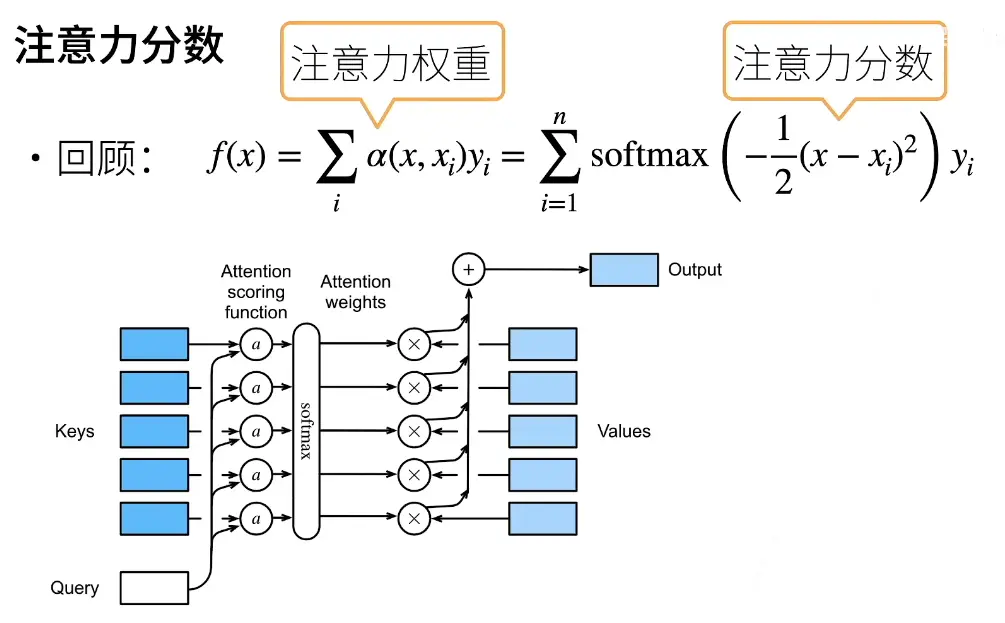

* **α（x,xi）**：注意力权重（权重一般是一组大于等于零，相加和为 1 的数）
* **注意力分数**：高斯核的指数部分（相当于是注意力权重归一化之前的版本）
* 上图所展示的是：假设已知一些 key-value 对和一个 query，首先将 query 和每一个 key 通过**注意力分数函数 a **和 **softmax** 运算得到注意力权重（**与 key 对应的值的概率分布**），将这些注意力权重再与已知的 value 进行**加权求和**，最终就得到了输出  

## 如何将 key 和 value 拓展到更高的维度

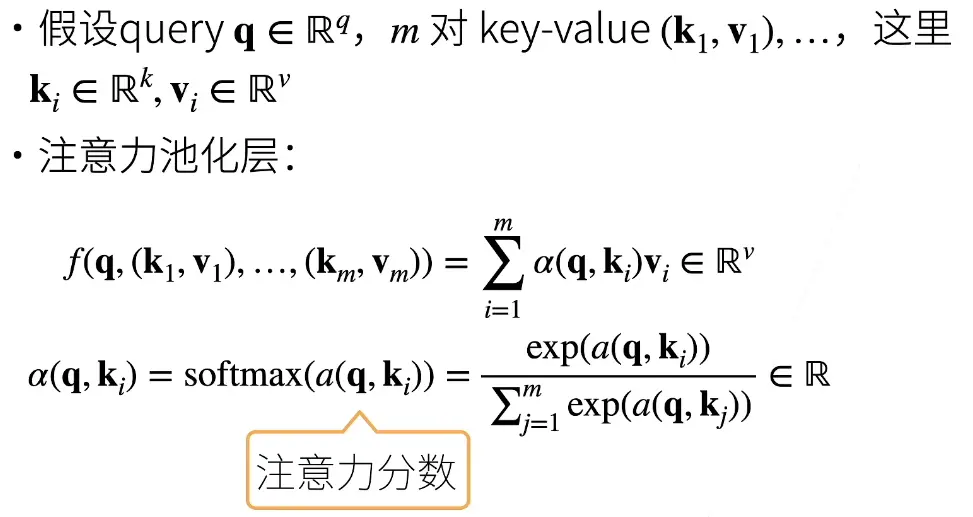

假设 query 是一个长为 q 的向量，ki 是长为 k 的向量，vi 是长为 v 的向量（**这里 key 和 value 的长度可以不同**）

其中 query 和 ki 的注意力权重是通过注意力评分函数 a 将两个向量映射成标量，再经过 softmax 运算得到的  

## 掩蔽 softmax 操作（masked softmax operation）

softmax 操作用于输出一个概率分布作为注意力权重，但是在某些情况下，并非所有的值都应该被纳入到注意力汇聚中

* 在处理文本数据集的时候，为了提高计算效率，可能会采用**填充**的方式使每个文本序列具有相同的长度，便于以相同形状的小批量进行加载，因此可能会存在一些文本序列被填充了没有意义的特殊词源（比如“\<pad>”词元）
* 因此，为了仅仅将有意义的词元作为值来获取注意力汇聚，可以指定一个有效序列长度（即词元的个数），**任何超出有效长度的位置都被掩蔽并置于 0，便于在计算 softmax 的时候过滤掉超出指定范围的位置**，这也就是掩蔽 softmax 操作

## 注意力分数函数 α 的设计 
### 1、加性注意力（Additive attention）
* 当 query 和 key 是不同长度的矢量时，可以使用加性注意力作为注意力分数
* 可学参数（ 3 个）： 

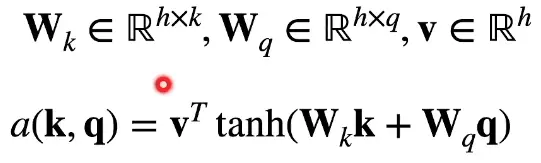

* h：超参数
* Wk：key 从 k map 到 h（将 key 向量的长度从 k 转化为 h）
* Wq：query 从q map 到 h（将 query 向量的长度从 q 转化为 h）
* Wk、Wq 都是矩阵，v 是向量
* tanh：激活函数
* 上式中，k 是长为 k 的向量，q 是长为 q 的向量
* 等价于将 query 和 key 合并起来变成一个长度为 k+q 的向量，然后将其输入到一个隐藏层大小为 h （ h 是一个超参数），输出大小为 1 的但隐藏层的 MLP（没有偏置项），最终得到输出
* 优点是**key、value 向量可以是任意的长度，可以不同**

2、缩放点积注意力（Scaled Dot-Product Attention）

使用点积可以得到计算效率更高i的评分函数，但是**点积操作要求 query 和 key 具有相同的长度**

针对 key 和 query 长度相同的情况

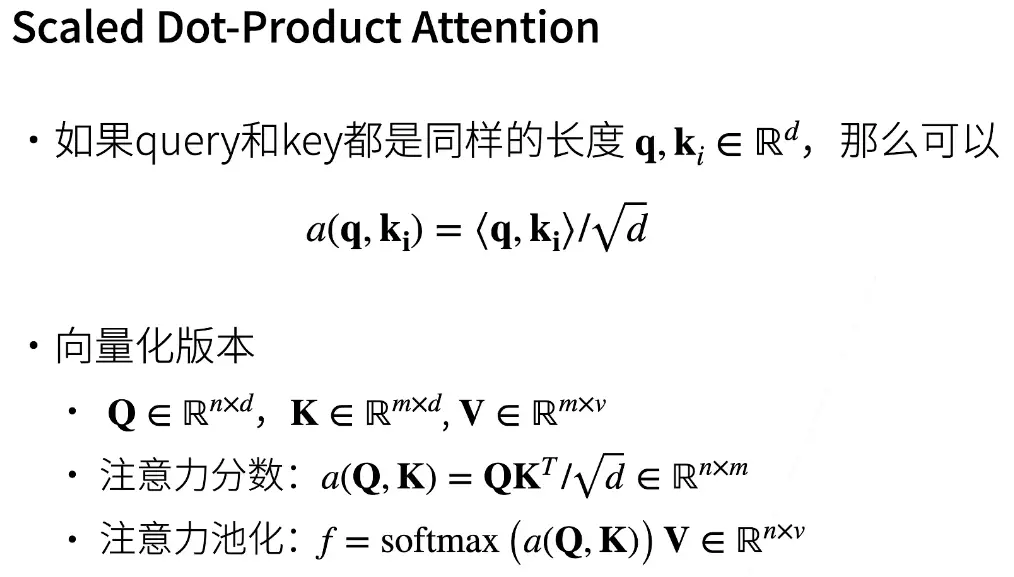

假设 query 和 key 的所有元素都是**独立的随机变量**，并且都满足**零均值和单位方差**，那么两个向量的点积的均值为 0 ，方差为 d

这里不需要学习任何东西，直接利用 <q,ki> 将 q 和 ki 做内积然后除以根号 d （**除以根号 d 的目的是为了降低对 ki 的长度的敏感度，使得无论向量的长度如何，点积的方差在不考虑向量长度的情况下仍然是 1**） 

## 总结
1、注意力分数是 query 和 key 的**相似度**（没有经过 normalize ），注意力权重是注意力分数的 softmax 结果（ 0 到 1 之间的数）

2、两种常见的注意力分数的计算

* **有参数的版本**：将 query 和 key 合并起来进入一个单隐藏层单输出的 MLP（在 query 和 key 向量长度不同的情况下）
* **无参数的版本**：直接将 query 和 key 做内积（在 query 和 key 向量长度一定的情况下），效率更高

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
# 遮蔽softmax操作
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上遮蔽元素来执行softmax操作"""
    if valid_lens is None:
        # 如果valid_lens为空，则对X执行softmax操作
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            # 将valid_lens重塑为一维向量
            valid_lens = valid_lens.reshape(-1)
        # 在X的最后一个维度上进行遮蔽操作，
        # 因为要做softmax，所以不能遮蔽元素不能设为0，设为一个很小的值，是exp指数之后的值为0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)   
        # 对遮蔽后的X执行softmax操作，并将形状还原为原始形状
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [3]:
# 演示此函数是如何工作
# 调用masked_softmax函数，并传入参数
masked_softmax(torch.rand(2,2,4), torch.tensor([2,3]))

tensor([[[0.6292, 0.3708, 0.0000, 0.0000],
         [0.3988, 0.6012, 0.0000, 0.0000]],

        [[0.3530, 0.3004, 0.3466, 0.0000],
         [0.4728, 0.2706, 0.2566, 0.0000]]])

In [4]:
masked_softmax(torch.rand(2,2,4), torch.tensor([[1,3],[2,4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3658, 0.2591, 0.3751, 0.0000]],

        [[0.6300, 0.3700, 0.0000, 0.0000],
         [0.1890, 0.3206, 0.2024, 0.2880]]])

In [5]:
# 加性注意力
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        # 用于转换键的线性变换
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        # 用于转换查询的线性变换
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        # 用于生成注意力分数的线性变换
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        # Dropout层，用于随机丢弃一部分注意力权重
        self.dropout = nn.Dropout(dropout)
        
    # valid_lens长度和queries长度一样，作用是指定每一个query应该考虑前多少个key-value pair
    def forward(self, queries, keys, values, valid_lens):
        # 将查询和键进行线性变换[batchsize,num_query,h], [batchsize,num_keys,h]
        queries, keys = self.W_q(queries), self.W_k(keys)
        print("1.",queries.shape,keys.shape)
        # 执行加性操作，将查询和键相加
        # [batchsize,num_query,num_keys,h]
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        print("2.", features.shape)
        # 使用双曲正切函数激活加性操作的结果
        features = torch.tanh(features)
        print("3.", features.shape)
        # 使用线性变换生成注意力分数，并将最后一维的维度压缩掉
        # [batchsize,num_query,num_keys]
        scores = self.w_v(features).squeeze(-1)
        print("4.", scores.shape)
        # 使用遮蔽softmax计算注意力权重
        self.attention_weights = masked_softmax(scores, valid_lens)
        print("5.", self.attention_weights.shape)
        # 根据注意力权重对values进行加权求和
        return torch.bmm(self.dropout(self.attention_weights), values)

In [6]:
# 演示上面的AdditiveAttention类
# 创建查询和键张量
queries, keys = torch.normal(0, 1, (2,1,20)), torch.ones((2,10,2))
# 创建值张量，每个batch中key和value的个数是一样，这里都是10
values = torch.arange(40, dtype=torch.float32).reshape(1,10,4).repeat(2,1,1) 

print("queries: ",queries.shape,",keys: ",keys.shape,",values: ",values.shape)

# 创建有效长度张量
valid_lens = torch.tensor([2,6])
# 创建加性注意力对象
attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)  
# 设置为评估模式，不使用dropout
attention.eval()
# 调用加性注意力对象的forward方法
attention(queries, keys, values, valid_lens) # torch.Size([2, 1, 4]))

queries:  torch.Size([2, 1, 20]) ,keys:  torch.Size([2, 10, 2]) ,values:  torch.Size([2, 10, 4])
1. torch.Size([2, 1, 8]) torch.Size([2, 10, 8])
2. torch.Size([2, 1, 10, 8])
3. torch.Size([2, 1, 10, 8])
4. torch.Size([2, 1, 10])
5. torch.Size([2, 1, 10])


tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

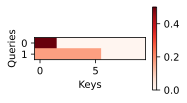

In [7]:
# 注意力权重
# 调用d2l.show_heatmaps函数，显示注意力权重的热图
d2l.show_heatmaps(attention.attention_weights.reshape((1,1,2,10)),
                 xlabel='Keys', ylabel='Queries')

In [8]:
# 缩放点积注意力
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        # Dropout层，用于随机丢弃一部分注意力权重
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, queries, keys, values, valid_lens=None):
        # 获取查询向量的维度d
        d = queries.shape[-1]
        # 计算点积注意力得分，并进行缩放
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        print("1.",scores.shape)
        # 使用遮蔽softmax计算注意力权重
        self.attention_weights = masked_softmax(scores, valid_lens)
        print("1.",self.attention_weights.shape)
        # 根据注意力权重对values进行加权求和
        return torch.bmm(self.dropout(self.attention_weights), values)

In [9]:
# 演示上述的DotProductAttention类
# 创建查询张量
queries = torch.normal(0,1,(2,1,2))

print("queries: ",queries.shape,",keys: ",keys.shape,",values: ",values.shape)

# 创建缩放点积注意力对象
attention = DotProductAttention(dropout=0.5)
# 设置为评估模式，不使用dropout
attention.eval()
# 调用缩放点积注意力对象的forward方法
attention(queries, keys, values, valid_lens)

queries:  torch.Size([2, 1, 2]) ,keys:  torch.Size([2, 10, 2]) ,values:  torch.Size([2, 10, 4])
1. torch.Size([2, 1, 10])
1. torch.Size([2, 1, 10])


tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

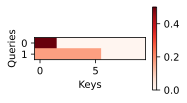

In [10]:
# 均匀的注意力权重
# 调用d2l.show_heatmaps函数，显示注意力权重的热图
d2l.show_heatmaps(attention.attention_weights.reshape((1,1,2,10)),
                 xlabel='Keys', ylabel='Queries')